## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from snprop import survey
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

### Use SED fitted SNf data

In [6]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr'].values**2 +
                               sed['mass_lowerr'].values**2)/2)
sedsnf_df = df_nc[df_nc['survey'] == 'SNF']
sedsnf_df['hostmass'] = sed['hostmass'].values
sedsnf_df['hostmass_err'] = sed['hostmass_err'].values
sedsnf_df_nonan = sedsnf_df[~np.isnan(sedsnf_df['hostmass'])]

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
tools.raw_df_snf.iloc[[10, 16, 81, 87]] 

,HR,HR.err,HR_o,HR_o.err,gmass,gmass.err_down,gmass.err_up,host.zcmb,host.zhelio,host.zhelio.err,...,salt2.Color.err,salt2.CovColorRestFrameMag_0_B,salt2.CovColorX1,salt2.CovRestFrameMag_0_BX1,salt2.RestFrameMag_0_B,salt2.RestFrameMag_0_B.err,salt2.X1,salt2.X1.err,target.dec,target.ra
13,-0.088795,0.136632,0.053230,0.084007,9.746044,0.100261,0.104981,0.028038,0.028107,0.000003,...,0.026816,0.000758,0.000205,0.000760,16.414515,0.032545,-0.296432,0.098238,35.509828,256.801708
19,0.176499,0.119955,0.425252,0.051994,9.501506,0.100825,0.099668,0.055268,0.055108,0.000083,...,0.027742,0.000822,0.000984,0.001843,18.305349,0.033897,-0.064233,0.170082,21.085342,247.580500
101,0.068608,0.118604,-0.166689,0.044396,8.540000,0.550000,0.650000,0.072460,0.071820,0.000050,...,0.027046,0.000752,0.000522,0.001322,18.329603,0.032720,0.462326,0.177360,18.853917,224.055542
107,-0.060055,0.126699,-0.408409,0.065367,8.615152,0.098953,0.098180,0.038349,0.037770,0.000060,...,0.026922,0.000756,0.000721,0.001271,16.650100,0.032481,0.831178,0.172913,4.904703,229.995458


## Use of `massevol` to determine a mass/age relationship

In [ ]:
im.Minuit().migrad()

In [9]:
gen = massevol.generic()
gen.set_model('Evol4G4M4S')
evol4G4M4S = gen.fit(sedsnf_df_nonan)#,
                     # limit_a=(0,1),
                     # limit_b=(0,1))

gen.set_model('Evol3G3M4S')
evol3G3M4S = gen.fit(sedsnf_df_nonan)#,
                     # limit_a=(0, 1),
                     # limit_mu_2=(8, 10),
                     # limit_mu=(10, 11))

gen.set_model('Evol3G3M3S')
evol3G3M3S = gen.fit(sedsnf_df_nonan)#,
                     # limit_a=(0,1),
                     # limit_sigma_2=(0, 3))#,
                     # limit_sigma_3=(0.2, 3))

gen.set_model('Evol2G2M3S')
evol2G2M3S = gen.fit(sedsnf_df_nonan)#,
                     # limit_sigma_1=(0, 3))

gen.set_model('Evol2G2M2S')
evol2G2M2S = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M2S')
evol1G1M2S = gen.fit(sedsnf_df_nonan)

gen.set_model('Evol1G1M1S')
evol1G1M1S = gen.fit(sedsnf_df_nonan)

mod_list = [evol1G1M1S, evol1G1M2S, evol2G2M2S, evol2G2M3S, evol3G3M3S, evol3G3M4S, evol4G4M4S]
mod_name = ['Evol'+mod.__doc__ for mod in mod_list]

pp = PrettyPrinter()
for mod in mod_list:
    print(mod.__doc__)
    pp.pprint(mod.param)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:209: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  self.migrad_out = self.m_tot.migrad()
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:461: RuntimeWarning: invalid value encountered in log
  mu_4, sigma_4)))
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/massevol.py:509: RuntimeWarning: invalid value encountered in log
  mu_3, sigma_3)))


1G1M1S
{'mu': 9.821876257041007, 'sigma': 0.7456061857908033}
1G1M2S
{'mu': 10.19375682906604,
 'sigmadown': 0.9740459104694558,
 'sigmaup': 0.4890663837776053}
2G2M2S
{'mu_1': 9.32233274708354,
 'mu_2': 10.341604799516755,
 'sigma_1': 0.5819364913116226,
 'sigma_2': 0.5095830489223027}
2G2M3S
{'mu': 10.556195811330182,
 'mu_1': 9.336563770080796,
 'sigma_1': -0.5837494222832381,
 'sigmadown': 0.7034738058948631,
 'sigmaup': 0.3426013149768933}
3G3M3S
{'a': 925917.6559375139,
 'mu_1': 1316.6864284007956,
 'mu_2': 9.668590788989235,
 'mu_3': -9571951.275227265,
 'sigma_1': -1705.360413734208,
 'sigma_2': -1.4152647633898296,
 'sigma_3': 2756516.667309893}
3G3M4S
{'a': 0.6221392284621564,
 'mu': 10.347755135581806,
 'mu_1': 9.34205674011098,
 'mu_2': 10.581461990023742,
 'sigma_1': 0.5773148422742942,
 'sigma_2': 0.3521668797294594,
 'sigmadown': 0.8541497554537839,
 'sigmaup': 5.869224602350918e-05}
4G4M4S
{'a': 0.5,
 'b': 0.5,
 'mu_1': 8.5,
 'mu_2': 10.0,
 'mu_3': 10.342936913153046,
 

In [14]:
for name, model in zip(mod_name[:2], mod_list[:2]):
    fig = plt.figure(figsize=[7, 3.5], facecolor='w')
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    
    print(name)
    model.show_model_tot(ax=ax)
    plt.title(model.__doc__)
    plt.close()
    
    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_SED-nonan.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_SED-nonan.png',
                bbox_inches='tight', dpi=600)
    
for name, model in zip(mod_name[2:], mod_list[2:]):
    fig = plt.figure(figsize=[7, 3.5], facecolor='w')
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    axh = fig.add_axes([0.75, 0.12, 0.2, 0.8])
 
    print(name)
    # gen.set_model(name)
    # mod = gen.model(snf_sed_nonan)
    # mod.param = model.param
    model.scatter(ax=ax, model=False)
    model.show_hist(ax=axh, bins=15)
    model.show_model(ax=axh,
                   o_factor=-model.amp*np.sum(1-model.py),
                   y_factor=model.amp*np.sum(model.py),
                   facealpha=0, edgealpha=1, lw=1, zorder=8)
    
    axh.set_ylim(*ax.get_ylim())
    axh.set_yticks([])
    axh.set_xticks([])
    
    axh.axvline(0, color='k', lw=1, zorder=10)
    
    axh.set_frame_on(False)
    
    plt.suptitle(model.__doc__)
    plt.close()

    fig.savefig('../../../Images/pdf/model_mass_' + model.__doc__ + '_hist_SED-nonan.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/model_mass_' + model.__doc__ + '_hist_SED-nonan.png',
                bbox_inches='tight', dpi=600)

Evol1G1M1S
Evol1G1M2S
Evol2G2M2S
Evol2G2M3S
Evol3G3M3S
Evol3G3M4S
Evol4G4M4S


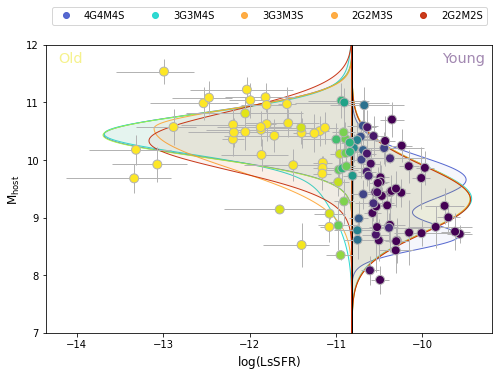

In [25]:
fig = plt.figure(figsize=[10, 5], facecolor='w')
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
evol4G4M4S.scatter(model=False, ax=ax)
#evol4G4M4S.show_hist(ax, yotext=False, alpha=.1)
evol4G4M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.1, 0.05), eco=plt.cm.turbo(0.1, 0.9),
                      fcy=plt.cm.turbo(0.1, 0.05), ecy=plt.cm.turbo(0.1, 0.9))
                      #o_factor=-evol4G4M4S.amp*np.sum(1-evol4G4M4S.py),
                      #y_factor=evol4G4M4S.amp*np.sum(evol4G4M4S.py))
#evol3G3M4S.show_hist(ax, yotext=False, alpha=0)
evol3G3M4S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.3, 0.05), eco=plt.cm.turbo(0.3, 0.9),
                      fcy=plt.cm.turbo(0.3, 0.05), ecy=plt.cm.turbo(0.3, 0.9))
                      #o_factor=-evol3G3M4S.amp*np.sum(1-evol3G3M4S.py),
                      #y_factor=evol3G3M4S.amp*np.sum(evol3G3M4S.py))
#evol3G3M3S.show_hist(ax, yotext=False, alpha=0)
evol3G3M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.5, 0.05), eco=plt.cm.turbo(0.5, 0.9),
                      fcy=plt.cm.turbo(0.5, 0.05), ecy=plt.cm.turbo(0.5, 0.9))
                      #o_factor=-evol3G3M3S.amp*np.sum(1-evol3G3M3S.py),
                      #y_factor=evol3G3M3S.amp*np.sum(evol3G3M3S.py))
#evol2G2M3S.show_hist(ax, yotext=False, alpha=0)
evol2G2M3S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.7, 0.05), eco=plt.cm.turbo(0.7, 0.9),
                      fcy=plt.cm.turbo(0.7, 0.05), ecy=plt.cm.turbo(0.7, 0.9))
                      #o_factor=-evol2G2M3S.amp*np.sum(1-evol2G2M3S.py),
                      #y_factor=evol2G2M3S.amp*np.sum(evol2G2M3S.py))
#evol2G2M2S.show_hist(ax, yotext=False, alpha=0)
evol2G2M2S.show_model(ax, shift=-10.82,
                      fco=plt.cm.turbo(0.9, 0.05), eco=plt.cm.turbo(0.9, 0.9),
                      fcy=plt.cm.turbo(0.9, 0.05), ecy=plt.cm.turbo(0.9, 0.9))
                      #o_factor=-evol2G2M2S.amp*np.sum(1-evol2G2M2S.py),
                      #y_factor=evol2G2M2S.amp*np.sum(evol2G2M2S.py))

from matplotlib.lines import Line2D

evol4G4M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.1,0.9), linewidth=0)
evol3G3M4Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.3,0.9), linewidth=0)
evol3G3M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.5,0.9), linewidth=0)
evol2G2M3Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.7,0.9), linewidth=0)
evol2G2M2Sleg = Line2D([0], [0], marker='o',
                       color=plt.cm.turbo(0.9,0.9), linewidth=0)
handles = [evol4G4M4Sleg, evol3G3M4Sleg, evol2G2M3Sleg, evol2G2M3Sleg, evol2G2M2Sleg]
labels = ['4G4M4S', '3G3M4S', '3G3M3S', '2G2M3S', '2G2M2S']

ax.legend(handles, labels,
          loc='upper center', fontsize='medium', ncol=5,
          bbox_to_anchor=(0.5, 1.0, 0.0, 0.15))

fig.savefig('../../../Images/pdf/models_mass_hist_SED-nonan.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/models_mass_hist_SED-nonan.png',
            bbox_inches='tight', dpi=600)

### Weird masses to Mat

In [32]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
#sed[(sed['mass'] > 8.2) &
#    (sed['mass'] < 9.)].to_csv('../../../Data/mass/weird_sedsnf.csv', sep=' ')

### Lowz masses to Mat

In [30]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')
lowz_df = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])]
lowz_df.to_csv('../../../Data/sne/lowz.csv', sep=' ')